In [1]:
import sgml, sgutil, sgpp, dproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from proc_v1 import p
from ml_v1 import X_cat, X_num, X_all, target, kf, ss, config
from ml_v1 import xgb_adapter, lgb_adapter, cb_adapter, lr_adapter

In [3]:
sc = sgutil.SGCache('img', 'result', 'model')
df_train = p.fit_transform('data/train.csv').assign(
    Calories_Log = lambda x: np.log(x['Calories'] + 1)
)
df_test = p.transform('data/test.csv')
len(df_train)

750000

# 1. Polynomial Feature Generation & Selection

- 1차, 1 / 1차, 2차, 1차 / 1차, 2차 / 1차, 1차 / 2차, 3차 속성을 만듭니다.
- 전체 속성으로 선형 모델을 학습 시키고, 회귀계수를 봅니다.
- 다중 공선성으로 인해 회귀계수가 커진 케이스가 확인 됐습니다. VIF를 측정하여 속성을 선별합니다.

In [4]:
from itertools import combinations, product

X_r = [i + '_r' for i in X_num]
X_o2 = [(i + '_2' if i == j else i + '_mul_'+ j, (i, j)) for i, j in product(X_num, X_num) if i <= j]
X_1d1 = [(i + '_div_' + j, (i, j)) for i, j in product(X_num, X_num) if i != j]
X_o2d1 = [
    (i + '_div_' + j, (i, j)) for (i, a), j in product(X_o2, X_num) if j not in a 
]
X_o1d2 = [
    (i + '_div_' + j, (i, j)) for i, (j, a) in product(X_num, X_o2) if i not in a 
]

X_o3 = [
    (
        i + '_3' if i == j and j == k else i + '_2_mul_' + k if i == j else i + '_2_mul_' + k if i == k  else j + '_2_mul_' + i if j == k else i + '_mul_' + j + '_mul_' + k,
        (i, j, k)
    )
    for i, j, k in product(X_num, X_num, X_num) if i <= j and i <= k and j <= k
]

In [5]:
var_list = [(1 / df_train[a]).rename(a + '_r') for a in X_num]
var_list.extend([(df_train[a].astype('float32') * df_train[b].astype('float32')).rename(i) for i, (a, b) in X_o2])
var_list.extend([(df_train[a].astype('float32') / df_train[b].astype('float32')).rename(i) for i, (a, b) in X_1d1])
var_list.extend([(df_train[a].astype('float32') * df_train[b].astype('float32') * df_train[c].astype('float32')).rename(i) for i, (a, b, c) in X_o3])

df_sel = dproc.join_and_assign(
    df_train,
    pd.concat(var_list, axis = 1)
)
df_sel = dproc.join_and_assign(
    df_sel,
    pd.concat([(df_sel[a] / df_sel[b]).rename(i) for i, (a, b) in X_o2d1 + X_o1d2], axis = 1)
)
df_sel.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log,Age_r,...,Body_Temp_div_Height_2,Body_Temp_div_Height_mul_Weight,Body_Temp_div_Weight_2,Body_Temp_div_Duration_mul_Height,Body_Temp_div_Duration_mul_Weight,Body_Temp_div_Duration_2,Body_Temp_div_Duration_mul_Heart_Rate,Body_Temp_div_Heart_Rate_mul_Height,Body_Temp_div_Heart_Rate_mul_Weight,Body_Temp_div_Heart_Rate_2
id,,,,,,,,,,,,,,,,,,,,,
0,True,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280,0.027778,...,0.001148,0.002646,0.006098,0.008344,0.019231,0.060651,0.015613,0.002148,0.004950,0.004019
1,False,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348,0.015625,...,0.001494,0.004059,0.011028,0.030445,0.082708,0.620313,0.058382,0.002865,0.007784,0.005495
2,False,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197,0.019608,...,0.001535,0.003863,0.009717,0.035315,0.088839,0.812245,0.067687,0.002943,0.007403,0.005641
3,True,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760,0.050000,...,0.001104,0.002355,0.005025,0.008479,0.018089,0.065120,0.015505,0.002019,0.004307,0.003692
4,False,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433,0.026316,...,0.001473,0.004009,0.010911,0.009783,0.026623,0.064960,0.015922,0.002398,0.006525,0.003902


In [6]:
var_list = [(1 / df_test[a]).rename(a + '_r') for a in X_num]
var_list.extend([(df_test[a].astype('float32') * df_test[b].astype('float32')).rename(i) for i, (a, b) in X_o2])
var_list.extend([(df_test[a].astype('float32') / df_test[b].astype('float32')).rename(i) for i, (a, b) in X_1d1])
var_list.extend([(df_test[a].astype('float32') * df_test[b].astype('float32') * df_test[c].astype('float32')).rename(i) for i, (a, b, c) in X_o3])

df_sel_test = dproc.join_and_assign(
    df_test,
    pd.concat(var_list, axis = 1)
)
df_sel_test = dproc.join_and_assign(
    df_sel,
    pd.concat([(df_sel[a] / df_sel[b]).rename(i) for i, (a, b) in X_o2d1 + X_o1d2], axis = 1)
)
df_sel_test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log,Age_r,...,Body_Temp_div_Height_2,Body_Temp_div_Height_mul_Weight,Body_Temp_div_Weight_2,Body_Temp_div_Duration_mul_Height,Body_Temp_div_Duration_mul_Weight,Body_Temp_div_Duration_2,Body_Temp_div_Duration_mul_Heart_Rate,Body_Temp_div_Heart_Rate_mul_Height,Body_Temp_div_Heart_Rate_mul_Weight,Body_Temp_div_Heart_Rate_2
id,,,,,,,,,,,,,,,,,,,,,
0,True,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280,0.027778,...,0.001148,0.002646,0.006098,0.008344,0.019231,0.060651,0.015613,0.002148,0.004950,0.004019
1,False,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348,0.015625,...,0.001494,0.004059,0.011028,0.030445,0.082708,0.620313,0.058382,0.002865,0.007784,0.005495
2,False,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197,0.019608,...,0.001535,0.003863,0.009717,0.035315,0.088839,0.812245,0.067687,0.002943,0.007403,0.005641
3,True,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760,0.050000,...,0.001104,0.002355,0.005025,0.008479,0.018089,0.065120,0.015505,0.002019,0.004307,0.003692
4,False,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433,0.026316,...,0.001473,0.004009,0.010911,0.009783,0.026623,0.064960,0.015922,0.002398,0.006525,0.003902


In [7]:
X_sel = [i for i in df_sel.columns if i not in ('Calories', 'Calories_Log')]

In [8]:
from sklearn.preprocessing import StandardScaler 
df_sel[X_sel] = StandardScaler().fit_transform(df_sel[X_sel])

In [9]:
result = sgml.cv(df_sel, ss, {'X_num': X_sel}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
rmse_all = result['valid_scores'][0]
rmse_all

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

0.06812648703353835

In [10]:
result['model_result'][0]['coef'].sort_values()

Age_mul_Body_Temp      -2677.607592
Weight_div_Body_Temp   -2300.548246
Heart_Rate_2           -2002.387703
Age_div_Body_Temp      -1874.426209
Body_Temp_mul_Weight   -1743.892064
                           ...     
Height_mul_Weight       2120.462377
Duration_div_Height     2484.250037
Duration_mul_Height     2901.800480
Age                     3203.112394
Weight                  3328.888977
Length: 300, dtype: float64

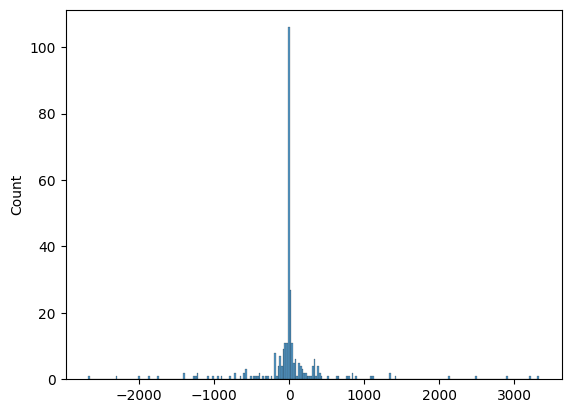

In [11]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

- 변수가 300개라 모든 변수를 가지고 순차적 선택을 하는 것에는 리소스에 무리가 있었습니다.

- 이를 보완 하기 위해, 차수가 낮은 것에서 시작하여 높은 것으로 그룹핑하여 추가를 해갑니다.

In [9]:
from cuml.linear_model import LinearRegression as cu_LinearRegression
lr_c_adapter = sgml.SklearnAdapter(cu_LinearRegression)

In [10]:
from tqdm.notebook import tqdm
import multiprocessing as mp

def get_rmse_c(X):
    return sgml.cv(df_sel, ss, {'X_num': X}, {**config, 'progress_callback': None}, lr_c_adapter)['valid_scores'][0]

def fs(X, X_ff):
    return pd.Series(
        {i: get_rmse_c(X + [i]) for i in X_ff if i not in X}
    ).sort_values()
def be(X, floated_list):
    if len(X) < 2: return pd.Series()
    return pd.Series(
        {i: get_rmse_c([j for j in X if j != i]) for i in X[:-1] if i not in floated_list}
    ).sort_values()

def step_fs(X_, X_selected, floated_list, rmse_list):
    while(True):
        s_rmse = fs(X_selected, X_)
        if len(s_rmse) == 0:
            break
        if rmse_list[-1] > s_rmse.iloc[0]:
            rmse_list.append(s_rmse.iloc[0])
            X_selected.append(s_rmse.index[0])
            print("Selected: {}, RMSE: {}".format(X_selected[-1], rmse_list[-1]))
        else:
            break
        while(True):
            s_rmse = be(X_selected, floated_list)
            if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
                rmse_list.append(s_rmse.iloc[0])
                floated_list.add(s_rmse.index[0])
                X_selected = [i for i in X_selected if i != s_rmse.index[0]]
                print("Excluded: {}, RMSE: {}".format(s_rmse.index[0], rmse_list[-1]))
            else:
                break
    return X_selected, floated_list, rmse_list

In [11]:
def get_rmse(v):
    i, X = v[0], v[1]
    return i, sgml.cv(df_sel, ss, {'X_num': X}, {**config, 'progress_callback': None}, lr_adapter)['valid_scores'][0]

def fs_mp(X, X_ff):
    X_list = [(i, X + [i]) for i in X_ff if i not in X]
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(get_rmse, X_list)
    return pd.Series(
        {k: v for k, v in results}
    ).sort_values()

def be_mp(X, floated_list):
    if len(X) < 2: return pd.Series()
    X_list = [(i, [j for j in X if j != i]) for i in X[:-1] if i not in floated_list]
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(get_rmse, X_list)
    return pd.Series(
        {k: v for k, v in results}
    ).sort_values()

def step_fs_mp(X_, X_selected, floated_list, rmse_list):
    while(True):
        s_rmse = fs_mp(X_selected, X_)
        if len(s_rmse) == 0:
            break
        if rmse_list[-1] > s_rmse.iloc[0]:
            rmse_list.append(s_rmse.iloc[0])
            X_selected.append(s_rmse.index[0])
            print("Selected: {}, RMSE: {}".format(X_selected[-1], rmse_list[-1]))
        else:
            break
        while(True):
            s_rmse = be_mp(X_selected, floated_list)
            if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
                rmse_list.append(s_rmse.iloc[0])
                floated_list.add(s_rmse.index[0])
                X_selected = [i for i in X_selected if i != s_rmse.index[0]]
                print("Excluded: {}, RMSE: {}".format(s_rmse.index[0], rmse_list[-1]))
            else:
                break
    return X_selected, floated_list, rmse_list

In [29]:
X_selected = list()
rmse_list = [np.inf]
X_ = X_num
X_selected, floated_list, rmse_list = sc.cache_result('fs_o1', lambda : step_fs(X_num, X_selected, set(), rmse_list), rerun = 0)
rmse_list[-1]

0.18064835569722082

In [30]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_r', lambda : step_fs(X_r, X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.11890502541192025

In [31]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o2', lambda : step_fs([i[0] for i in X_o2], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.08281917544819209

In [32]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_1d1', lambda : step_fs([i[0] for i in X_1d1], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07591978840844088

In [33]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o2d1', lambda : step_fs_mp([i[0] for i in X_o2d1], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.0718067288948422

In [34]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o1d2', lambda : step_fs_mp([i[0] for i in X_o1d2], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07070597741714742

In [35]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o3', lambda : step_fs_mp([i[0] for i in X_o3], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07054807770710889

In [36]:
result = sgml.cv(df_sel, ss, {'X_num': X_selected}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07054807770711112]

In [21]:
len(X_selected), np.array(X_selected)

(98,
 array(['Body_Temp', 'Duration', 'Duration_2', 'Body_Temp_mul_Duration',
        'Body_Temp_mul_Weight', 'Weight_2', 'Age_mul_Height',
        'Body_Temp_div_Duration', 'Weight_div_Heart_Rate',
        'Age_div_Weight', 'Heart_Rate_div_Body_Temp',
        'Weight_div_Duration', 'Body_Temp_div_Weight', 'Height_div_Age',
        'Weight_2_div_Heart_Rate', 'Duration_2_div_Body_Temp',
        'Heart_Rate_2_div_Duration', 'Weight_2_div_Age',
        'Height_mul_Weight_div_Body_Temp', 'Height_mul_Weight_div_Age',
        'Age_mul_Weight_div_Height', 'Age_mul_Height_div_Weight',
        'Body_Temp_mul_Heart_Rate_div_Duration',
        'Heart_Rate_2_div_Body_Temp', 'Heart_Rate_2_div_Weight',
        'Weight_2_div_Duration', 'Duration_mul_Heart_Rate_div_Body_Temp',
        'Duration_2_div_Heart_Rate', 'Body_Temp_2_div_Weight',
        'Height_2_div_Body_Temp', 'Age_2_div_Heart_Rate',
        'Age_mul_Weight_div_Duration', 'Heart_Rate_mul_Weight_div_Age',
        'Age_mul_Weight_div_Heart_R

In [37]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Body_Temp_mul_Duration            -628.440215
Height_mul_Weight_div_Body_Temp    -55.189597
Duration_div_Body_Temp_2           -46.878210
Duration_2_div_Body_Temp           -45.344002
Heart_Rate_div_Body_Temp           -42.269036
                                      ...    
Weight_div_Body_Temp_2              52.618924
Body_Temp_mul_Weight                76.852817
Duration_2                          86.418111
Body_Temp_2_mul_Duration           238.878689
Duration                           472.902968
Length: 98, dtype: float64

In [ ]:
from sklearn.linear_model import Lasso
result = sgml.cv(df_sel, ss, {'model_params': {'alpha': 1e-6, 'max_iter': 2000}, 'X_num': X_sel}, config, sgml.SklearnAdapter(Lasso), result_proc = [sgml.lr_learning_result])
result['valid_scores']

In [ ]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

In [40]:
from sklearn.linear_model import Ridge
result = sgml.cv(df_sel, ss, {'model_params': {'alpha': 1e-3}, 'X_num': X_sel}, config, sgml.SklearnAdapter(Ridge), result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.068523406731391]

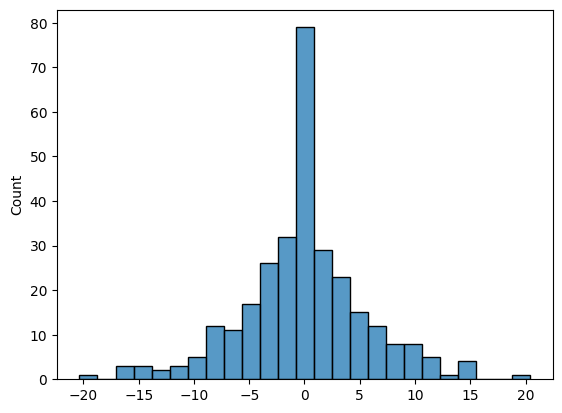

In [41]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

In [42]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Heart_Rate                              -20.365835
Body_Temp_2_mul_Duration                -16.865307
Heart_Rate_2_mul_Duration               -16.786587
Heart_Rate_div_Body_Temp                -15.564463
Weight_2_mul_Body_Temp                  -14.918791
                                           ...    
Body_Temp_mul_Duration_mul_Heart_Rate    14.198431
Age_mul_Height_mul_Weight                14.302717
Body_Temp_div_Heart_Rate_2               14.497902
Heart_Rate_2_div_Body_Temp               15.153733
Heart_Rate_2_mul_Body_Temp               20.439106
Length: 300, dtype: float64

- Backward Eliminations를 사용해봅니다.

In [43]:
def be_mp2(X, floated_list):
    if len(X) < 2: return pd.Series()
    X_list = [(i, [j for j in X if j != i]) for i in X if i not in floated_list]
    results = {}
    for k, v in tqdm(X_list):
        results[k] = get_rmse_c(v)
    return pd.Series(results).sort_values()

el = list()
rmse_list = [get_rmse_c(X_sel)]
cnt = 0
while(True):
    s_rmse = sc.cache_result(
        'be_{}'.format(cnt), lambda : be_mp2([i for i in X_sel if i not in el], set())
    )
    cnt += 1
    if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
        rmse_list.append(s_rmse.iloc[0])
        el.append(s_rmse.index[0])
        print("Excluded: {}, RMSE: {}".format(el[-1], rmse_list[-1]))
    else:
        break

Excluded: Height_div_Body_Temp, RMSE: 0.0683271831562596


  0%|          | 0/299 [00:00<?, ?it/s]

- 공선성이 큰 속성을 제외해봅니다.

In [12]:
from sklearn.metrics import r2_score
el = list()
el_r2 = list()
def get_r2(X_var):
    r2_scores = list()
    for i in tqdm(X_var):
        X_ = [j for j in X_var if j != i]
        r2_scores.append(
            r2_score(
                df_sel[i], cu_LinearRegression().fit(df_sel[X_], df_sel[i]).predict(df_sel[X_])
            )
        )
    return pd.Series(r2_scores, index = X_var).sort_values(ascending = False)
for i in range(10):
    s_r2 = sc.cache_result(
        'r2_X_sel_{}'.format(i), 
        lambda : get_r2([j for j in X_sel if j not in el])
    )
    el.append(s_r2.index[0])
    el_r2.append(s_r2.iloc[0])
    print(el[-1], el_r2[-1])

Body_Temp_div_Duration_2 0.9999913567875099


  0%|          | 0/299 [00:00<?, ?it/s]

Age_r 0.9999953079382987


  0%|          | 0/298 [00:00<?, ?it/s]

Body_Temp_div_Age 0.9999989677957916


  0%|          | 0/297 [00:00<?, ?it/s]

Age_div_Body_Temp_mul_Height 0.9999982978002212


  0%|          | 0/296 [00:00<?, ?it/s]

Height_div_Age 0.9999988653712294


  0%|          | 0/295 [00:00<?, ?it/s]

Age_div_Body_Temp 0.9999996388095074


  0%|          | 0/294 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
from sklearn.linear_model import Ridge
result = sgml.cv(df_sel, ss, {'X_num': [j for j in X_sel if j not in el]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.06811883784790934]

In [15]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Weight_div_Body_Temp                -2322.891299
Heart_Rate_2                        -1873.251660
Body_Temp_mul_Weight                -1866.182069
Duration_mul_Height_div_Body_Temp   -1549.394152
Body_Temp_mul_Duration_mul_Height   -1545.901877
                                        ...     
Heart_Rate                           1384.021251
Height_mul_Weight                    2115.136911
Duration_div_Height                  2499.302690
Duration_mul_Height                  3183.656363
Weight                               3407.901617
Length: 294, dtype: float64